# **Saving boxes 10°x10°**

In [141]:
# ---------------------------------------------------
# 1. Load libraries
# ---------------------------------------------------
import json
import shapely.ops as so
from shapely.geometry import Polygon, mapping
import cartopy.feature as cfeature
import numpy as np
from scipy.ndimage import binary_erosion
import matplotlib.pyplot as plt


In [142]:

# ---------------------------------------------------
# 1. Load land polygons (Natural Earth)
# ---------------------------------------------------
land_geoms = list(
    cfeature.NaturalEarthFeature("physical", "land", "110m").geometries()
)

# Merge all land into one geometry (faster)
land = so.unary_union(land_geoms)





In [143]:
# -----------------------------
# 2. Create 10x10° grid and compute % land
# -----------------------------
# Define range of latitude and longitude 
# It is selected -/+70°for the latitude to avoid latitude minor to 75° and also to be in agree with the dimension 10x10°
lat_min=-70
lat_max=70
lon_min=-180
lon_max=180

perc=10 # maximum percentage of land for box 

nlat = 16  # 160/10
nlon = 36  # 360/10
latitudes = np.arange(lat_min, lat_max, 10)
longitudes = np.arange(lon_min, lon_max, 10)

# Arrays to store % land and mask of valid boxes
percent_land_grid = np.zeros((nlat, nlon))
mask_grid = np.zeros((nlat, nlon), dtype=int)  # 1 = mostly ocean, 0 = land or <10% ocean

features = []

for i, lat in enumerate(latitudes):
    for j, lon in enumerate(longitudes):

        # Create 10x10 deg box
        box = Polygon([
            (lon, lat),
            (lon + 10, lat),
            (lon + 10, lat + 10),
            (lon, lat + 10),
        ])

        box_area = box.area

        # Intersection with land
        inter = box.intersection(land)
        land_area = inter.area if not inter.is_empty else 0.0

        # % land
        percent_land = 100 * land_area / box_area
        percent_land_grid[i, j] = percent_land

        # Initially mark boxes with <10% land as ocean
        if percent_land < 10:
            mask_grid[i, j] = 1


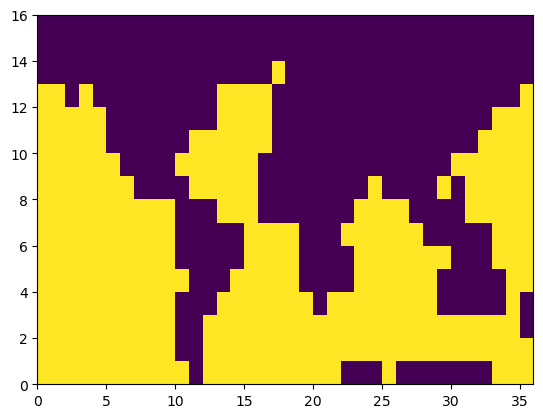

In [144]:
plt.pcolormesh(mask_grid)

In [149]:
# -----------------------------
# 3. Remove enclosed ocean boxes
# -----------------------------

def surrounded_by_zeros(arr):
    positions = []
    rows, cols = arr.shape
    for i in range(1, rows-1):
        for j in range(1, cols-1):
            if arr[i, j] == 1:
                # Get the 8 neighbors
                neighbors = arr[i-1:i+2, j-1:j+2].copy()
                neighbors[1,1] = 0  # ignore the center
                if np.all(neighbors == 0) :
                    positions.append((i, j))
                elif np.sum(neighbors == 0) == 8:
                    positions.append((i, j))
    return positions
# -----------------------------
pos_surr= surrounded_by_zeros(mask_grid)
filtered_boxes=np.copy(mask_grid)
boolean_mask = np.zeros_like(filtered_boxes, dtype=bool)
for i,j in pos_surr:
    if i < filtered_boxes.shape[0] and j < filtered_boxes.shape[1]:
        boolean_mask[i,j] = True

mask_filtered[boolean_mask] = 0


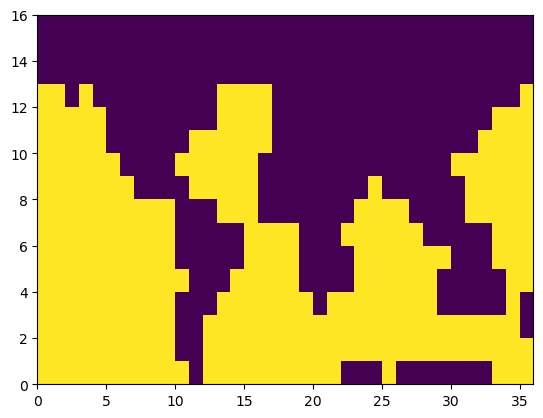

In [150]:
plt.pcolormesh(mask_filtered)

In [151]:
# -----------------------------
# 4. Create GeoJSON
# -----------------------------
features = []
box_id = 0
for i, lat in enumerate(latitudes):
    for j, lon in enumerate(longitudes):
        if mask_filtered[i, j] == 1:
            box_id += 1
            box = Polygon([
                (lon, lat),
                (lon + 10, lat),
                (lon + 10, lat + 10),
                (lon, lat + 10),
            ])
            # make sure all numbers are native Python types
            features.append({
                "type": "Feature",
                "properties": {
                    "id": int(box_id),
                    "lon": float(lon),
                    "lat": float(lat),
                    "percent_land": float(percent_land_grid[i,j])
                },
                "geometry": mapping(box)
            })

geojson = {"type": "FeatureCollection", "features": features}

with open("mostly_ocean_boxes_filtered.geojson", "w") as f:
    json.dump(geojson, f)